<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Тренд-и-сезонность" data-toc-modified-id="Тренд-и-сезонность-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Тренд и сезонность</a></span></li><li><span><a href="#Стат-тест-Дики-Фуллера-(проверка-на-стационарность)" data-toc-modified-id="Стат-тест-Дики-Фуллера-(проверка-на-стационарность)-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Стат тест Дики-Фуллера (проверка на стационарность)</a></span></li><li><span><a href="#Автокорреляция" data-toc-modified-id="Автокорреляция-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Автокорреляция</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Подготовка-признаков.-Деление-на-выборки" data-toc-modified-id="Подготовка-признаков.-Деление-на-выборки-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Подготовка признаков. Деление на выборки</a></span></li><li><span><a href="#Линейная-регрессия" data-toc-modified-id="Линейная-регрессия-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Линейная регрессия</a></span></li><li><span><a href="#Catboost" data-toc-modified-id="Catboost-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Catboost</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Выбор-и-тест-лучшей-модели" data-toc-modified-id="Выбор-и-тест-лучшей-модели-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Выбор и тест лучшей модели</a></span></li><li><span><a href="#Проверка-на-адекватность" data-toc-modified-id="Проверка-на-адекватность-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Проверка на адекватность</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [ ]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [ ]:
import warnings
warnings.filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels. tsa.stattools import adfuller
from statsmodels.graphics import tsaplots

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

from catboost import CatBoostRegressor

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    RandomizedSearchCV,
    GridSearchCV,)

plt.rcParams["figure.figsize"] = (10,10)

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
df.sort_index(inplace=True)

In [ ]:
df.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


Видим, что в датасете шаг 10 минут

In [ ]:
df.tail(7)

,num_orders
datetime,
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
df.isna().mean()

num_orders    0.0
dtype: float64

Пропусков в данных нет

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_orders,26496.0,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


26496 строк, среднее значение количества заказов 14, дисперсия 9.2

In [ ]:
print(f'В датасете даты, начиная с {df.index.min()} до {df.index.max()}');

В датасете даты, начиная с 2018-03-01 00:00:00 до 2018-08-31 23:50:00


Проверка даных на монотонность (в хронологическом ли порядке расположены даты)

In [ ]:
df.index.is_monotonic

True

## Анализ

### Тренд и сезонность

Так как по задаче нам надо предсказать количество заказов на следующий час, то выполним ресемплирование с шагом 1 час и аггрегирующей функцией sum()

In [ ]:
df = df.resample('1H').sum()

In [ ]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


В этом случае 124 заказа суммарно было в период времени с 00:00 до 01:00

In [ ]:
df.tail()

,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


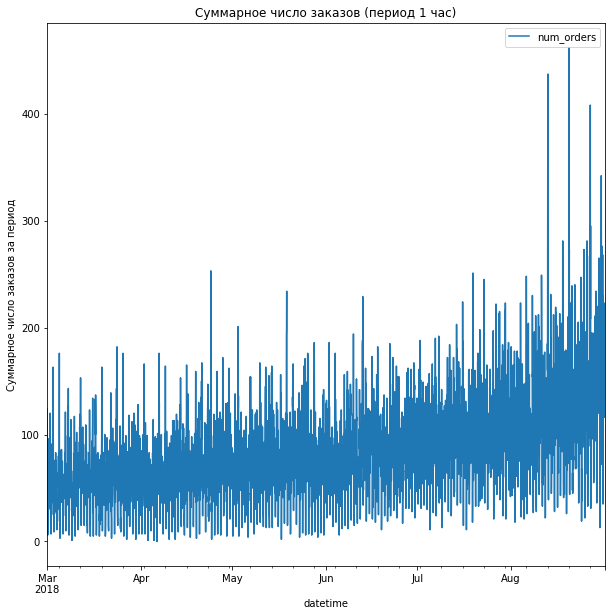

In [ ]:
df.plot();

plt.title('Суммарное число заказов (период 1 час)');

plt.ylabel('Суммарное число заказов за период');

По такому графику трудно сделать какие-либо выводы. Добавим скользящую среднюю и затем выделим тренд, сезонность и шум

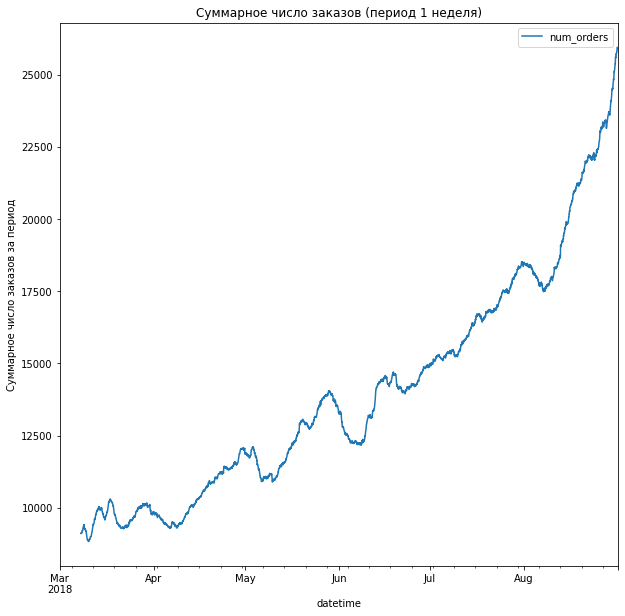

In [ ]:
df.rolling(168).sum().plot();
plt.title('Суммарное число заказов (период 1 неделя)');

plt.ylabel('Суммарное число заказов за период');

Выбрав период скользящей в 3 дня мы видим, что суммарное количество растет

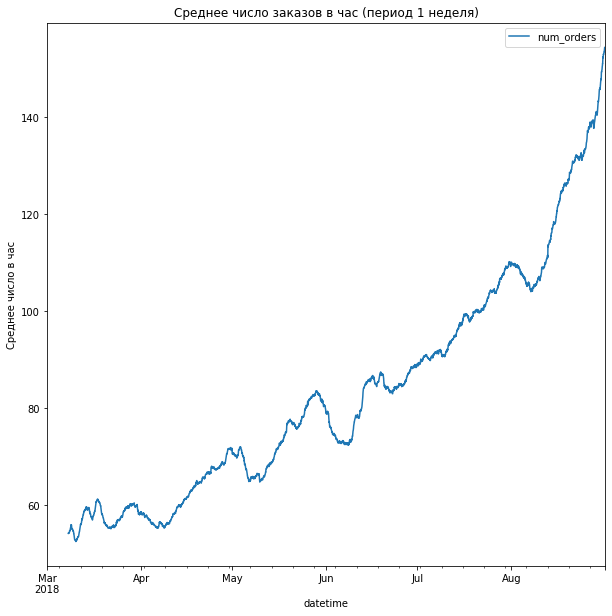

In [ ]:
df.rolling(168).mean().plot();

plt.title('Среднее число заказов в час (период 1 неделя)');

plt.ylabel('Среднее число в час');

Видим, что важный для нас показатель "число заказов в час" растет.

Посмотрим тренд и сезонность

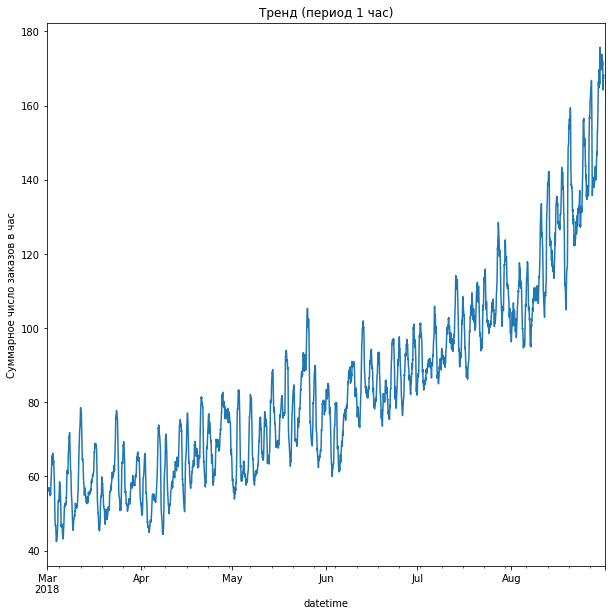

In [ ]:
decomposed = seasonal_decompose(df)

decomposed.trend.plot()

plt.title('Тренд (период 1 час)');

plt.ylabel('Суммарное число заказов в час');

Восходящий тренд потдверждает наши выводы о росте числа заказов к августу

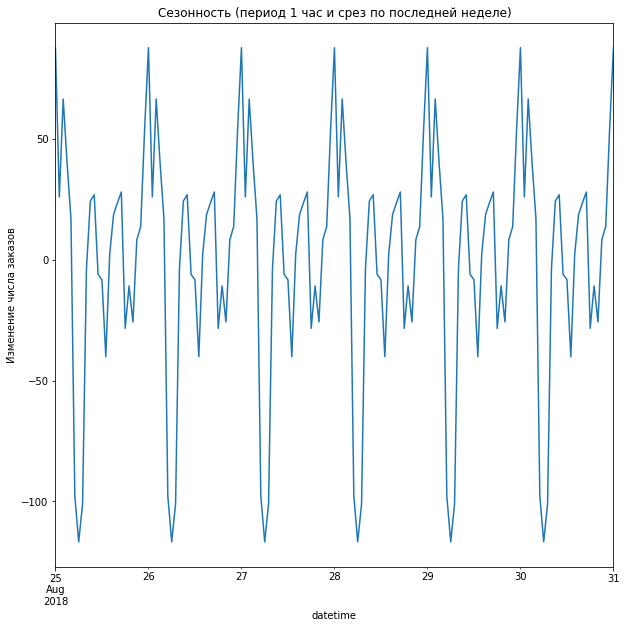

In [ ]:
seasonal_decompose(df['2018-08-25 00:00:00':'2018-08-31 00:00:00']).seasonal.plot();

plt.title('Сезонность (период 1 час и срез по последней неделе)');

plt.ylabel('Изменение числа заказов');

Для большей наглядности - сделаем ресемплирование по 1 дню и посмотрим тренд и сезонность

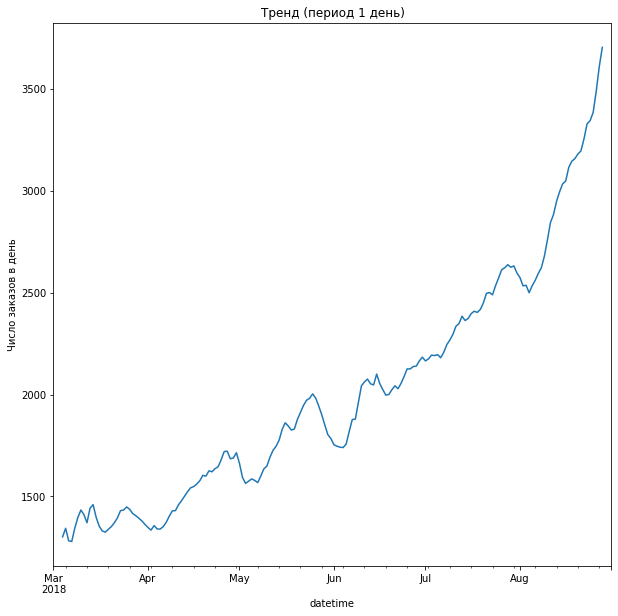

In [ ]:
decomposed = seasonal_decompose(df.resample('1D').sum())

decomposed.trend.plot();

plt.title('Тренд (период 1 день)');

plt.ylabel('Число заказов в день');

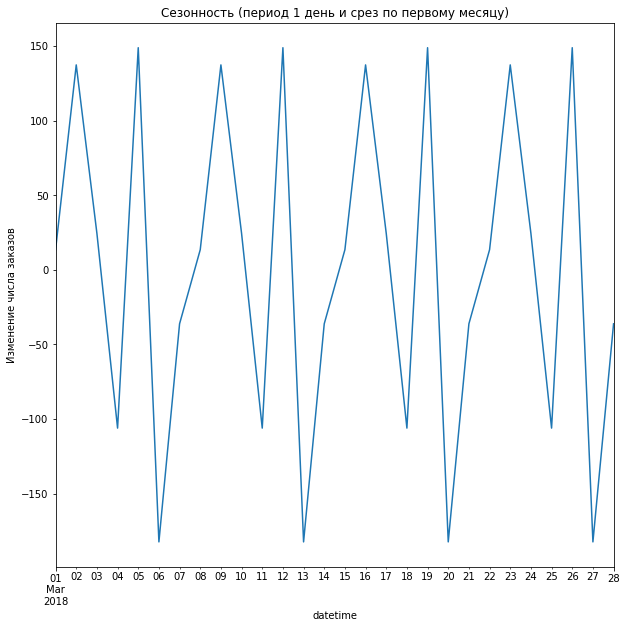

In [ ]:
decomposed.seasonal['2018-03-01':'2018-03-28'].plot();

plt.title('Сезонность (период 1 день и срез по первому месяцу)');

plt.ylabel('Изменение числа заказов');

Видим:
- присутствует восходящий тренд (рост числа заказов от марта к августу)
- есть сезонность по неделям (т.е. каждую неделю картина по дням недели с числом заказов повторяется)

### Стат тест Дики-Фуллера (проверка на стационарность)

Основная идея теста заключается в подтверждении или отклонении двух гипотез:

Нулевая гипотеза (H0): предполагает, что временной ряд имеет единичный корень, то есть он нестационарный

Альтернативная гипотеза (H1): предполагает, что временной ряд не имеет единичного корня, то есть он является стационарным

In [ ]:
test = adfuller(df)

alpha = 0.05 #уровень стат значимости

print(f'Статистика теста = {test[0]}')
print(f'p_value = {test[1]}')

if test[1] < alpha:
    print('H0 отвергается - ряд стационарный')
else:
    print('Не можем отвергнуть Н0 - ряд не стационарен')

Статистика теста = -3.0689242890279558
p_value = 0.028940051402612906
H0 отвергается - ряд стационарный


In [ ]:
print(f'Critical values {test[4]}')

Critical values {'1%': -3.431842162413052, '5%': -2.8621993540813637, '10%': -2.567120978470452}


In [ ]:
if test[0] < test[4]['5%']:
    print('H0 отвергается - ряд стационарный')
else:
    print('Не можем отвергнуть Н0 - ряд не стационарен')

H0 отвергается - ряд стационарный


Получается, что по результатам стат теста - ряд стационарный.

### Автокорреляция

Автокорреляция измеряет степень сходства между временным рядом и его запаздывающей версией в течение последовательных интервалов времени.

Его также иногда называют «последовательной корреляцией» или «запаздывающей корреляцией», поскольку он измеряет взаимосвязь между текущими значениями переменной и ее историческими значениями.

Когда автокорреляция во временном ряду высока, становится легко предсказать будущие значения, просто ссылаясь на прошлые значения.

Посмотрим коррелограмму

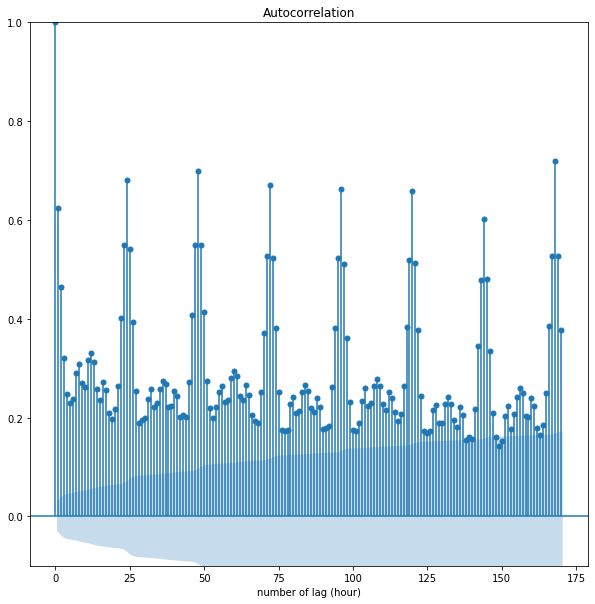

In [ ]:
#plot autocorrelation function
fig = tsaplots.plot_acf(df, lags=170) #зададим максимальный лаг в 1 неделю (опираясь на сезоность)
plt.ylim(-0.1, 1)

plt.xlabel('number of lag (hour)')
plt.show()

Видим, что экстремумы приходятся на сутки (каждый 24 часа картина заказов с высокой вероятностью повторяется) и на 168 часов (недели походи друг на друга - сезонность)

Выводы:

- по результатам стат теста Дики-Фулера - ряд стационарный
- по резльтатам коррелограммы видим, что экстремумы приходятся на сутки (каждый 24 часа картина заказов с высокой вероятностью повторяется) и на 168 часов (недели походи друг на друга - сезонность)
- среднее число заказов в час расте от матра к августу

## Обучение

Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.

### Подготовка признаков. Деление на выборки

Зададим функцию по созданию признаков make_features

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek

    for lag in range(1, max_lag + 1):
        data[f'lag_{lag}'] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [ ]:
#применим функцию make_features
make_features(df, 168, 24)

train, test = train_test_split(df, test_size=0.1, shuffle=False)

train = train.dropna()

X_train = train.drop(columns='num_orders')
y_train = train['num_orders']

X_test = test.drop(columns='num_orders')
y_test = test['num_orders']

X_train.head()

,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-08 00:00:00,0,3,94.0,127.0,108.0,76.0,50.0,99.0,48.0,46.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,60.041667
2018-03-08 01:00:00,1,3,143.0,94.0,127.0,108.0,76.0,50.0,99.0,48.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,61.833333
2018-03-08 02:00:00,2,3,78.0,143.0,94.0,127.0,108.0,76.0,50.0,99.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,60.041667
2018-03-08 03:00:00,3,3,65.0,78.0,143.0,94.0,127.0,108.0,76.0,50.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,61.750000
2018-03-08 04:00:00,4,3,68.0,65.0,78.0,143.0,94.0,127.0,108.0,76.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,61.833333


### Линейная регрессия

In [ ]:
%%time

model_ridge = Ridge()

parameters = {
    'alpha' : np.arange(0,1,0.01)
}

grid = RandomizedSearchCV(
    estimator=model_ridge,
    param_distributions=parameters,
    cv=TimeSeriesSplit(n_splits=5),
    n_jobs=-1,
    n_iter=20,
    error_score='raise',
    random_state=42,
    scoring='neg_mean_squared_error') #настраиваем скориннг на mse

grid.fit(X_train, y_train)

CPU times: user 17.8 s, sys: 28.7 s, total: 46.6 s
Wall time: 46.6 s


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
                   error_score='raise', estimator=Ridge(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33,....39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99])},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
print(f'Best_model: {grid.best_estimator_}')
print(f'Best_parametrs: {grid.best_params_}')
print(f'Best RMSE: {(-grid.best_score_)**(0.5)}')

RMSE_linear_regression = (-grid.best_score_)**(0.5)

Best_model: Ridge(alpha=0.9)
Best_parametrs: {'alpha': 0.9}
Best RMSE: 22.69494792955489


In [ ]:
model_list = []

In [ ]:
model_list.append(('Linear Regression', RMSE_linear_regression))

### Catboost

In [ ]:
%%time

cat_model = CatBoostRegressor(iterations = 200,
                        loss_function='RMSE',
                        verbose = False,
                        cat_features = [],
                       random_seed=42)

parameters = {'learning_rate': [0.1, 0.5, 0.75],
             'depth': [2,4,6]}

grid = GridSearchCV(
    estimator=cat_model,
    param_grid = parameters,
    cv=TimeSeriesSplit(n_splits=3),
    n_jobs=-1,
    scoring='neg_mean_squared_error') #настраиваем скориннг на mse

grid.fit(X_train, y_train)

CPU times: user 1min 21s, sys: 976 ms, total: 1min 22s
Wall time: 1min 48s


GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=<catboost.core.CatBoostRegressor object at 0x7f13c1d948b0>,
             n_jobs=-1,
             param_grid={'depth': [2, 4, 6], 'learning_rate': [0.1, 0.5, 0.75]},
             scoring='neg_mean_squared_error')

In [ ]:
print(f'Best_model: {grid.best_estimator_}')
print(f'Best_parametrs: {grid.best_params_}')
print(f'Best RMSE: {(-grid.best_score_)**(0.5)}')

RMSE_CatBoost = (-grid.best_score_)**(0.5)

Best_model: <catboost.core.CatBoostRegressor object at 0x7f13c1e2b6a0>
Best_parametrs: {'depth': 4, 'learning_rate': 0.1}
Best RMSE: 23.46488500982552


Лучший результат показала модель с неглубокими деревьями и малой скоростью обучения

In [ ]:
model_list.append(('CatBoost', RMSE_CatBoost))

## Тестирование

### Выбор и тест лучшей модели

Посмотрим на результаты моделей

In [ ]:
ml = pd.DataFrame(model_list, columns=['Model', 'RMSE_train'])
ml = ml.sort_values(by='RMSE_train')
ml

,Model,RMSE_train
0,Linear Regression,22.694948
1,CatBoost,23.464885


Лучшей моделью оказалась линейная регресия

Проверим её на тестовой выборке

In [ ]:
best_model = Ridge(alpha=0.9)
best_model.fit(X_train, y_train)

RMSE_test = mean_squared_error(y_test, best_model.predict(X_test), squared=False)

print(f'RMSE_test = {RMSE_test}')

RMSE_test = 34.52644834849409


In [ ]:
df_model = pd.DataFrame(best_model.predict(X_test), index=y_test.index)
df_model.columns=['num_orders_predict']

In [ ]:
df_model.head()

,num_orders_predict
datetime,
2018-08-13 14:00:00,121.004484
2018-08-13 15:00:00,128.037173
2018-08-13 16:00:00,187.638347
2018-08-13 17:00:00,133.561960
2018-08-13 18:00:00,92.358197


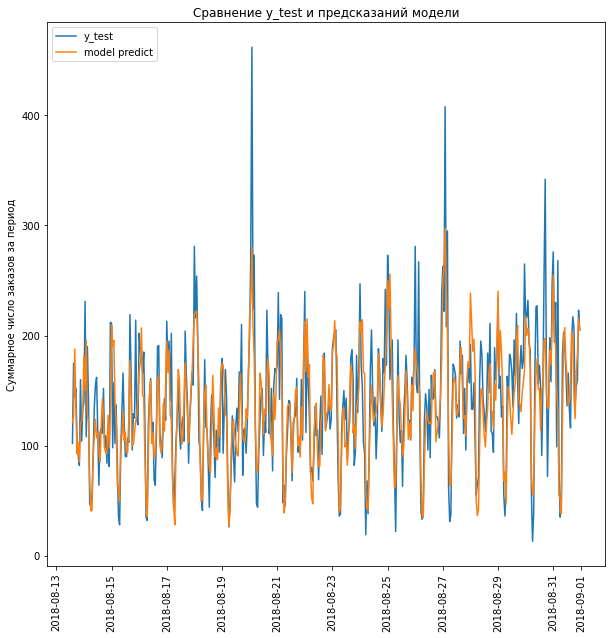

In [ ]:
plt.plot(y_test, label='y_test')
plt.plot(df_model['num_orders_predict'], label='model predict')

plt.legend(loc='upper left');

plt.title('Сравнение y_test и предсказаний модели');

plt.ylabel('Суммарное число заказов за период');

plt.xticks(rotation=90);

Видим, что модель существенно ошибается в моменты резкого всплеска спроса на такси, т.е. модель "чувствует" ритм спроса, но не дооценивает амплитуду

In [ ]:
df_model['residual'] = y_test - df_model['num_orders_predict']

In [ ]:
df_model.head()

,num_orders_predict,residual
datetime,,
2018-08-13 14:00:00,121.004484,-19.004484
2018-08-13 15:00:00,128.037173,46.962827
2018-08-13 16:00:00,187.638347,-43.638347
2018-08-13 17:00:00,133.561960,18.438040
2018-08-13 18:00:00,92.358197,11.641803


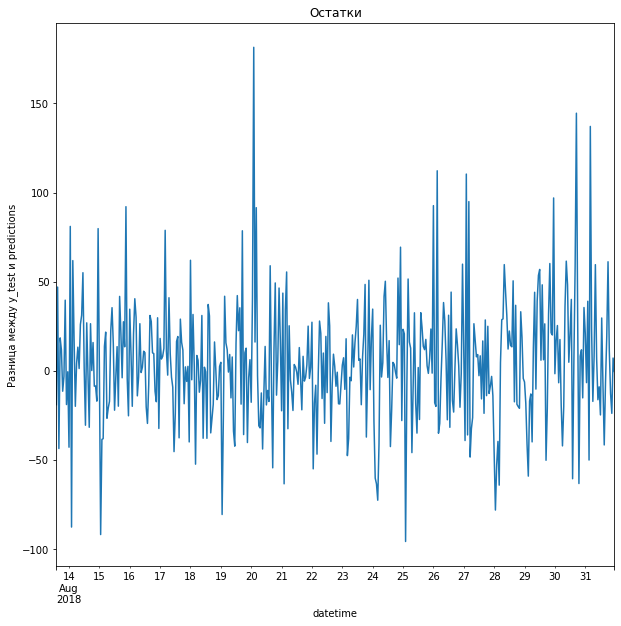

In [ ]:
df_model['residual'].plot()

plt.title('Остатки');

plt.ylabel('Разница между y_test и predictions');

In [ ]:
df_model['residual'].mean()

4.23605861379696

Мат ожидание по остаткам должно быть 0, а у нас среднее 4.

Эти ошибки возникают тз-за того, что модель существенно ошибается в моменты резкого всплеска спроса на такси, т.е. модель "чувствует" ритм спроса, но не дооценивает амплитуду. Здесь можем попробовать ввести повышающий кф в моменты резкого спроса. Порог определим в 200 заказов в час. Т.е. когда модель предсказывает 200 и более - мы будем домножать её ответ на повышающий кф 1.1

In [ ]:
#создадим вспомогательную функцию

def coef(value):
    #a = row['num_orders_predict']
    if value >= 200:
        return 1.1 * value
    else:
        return value

In [ ]:
#применим эту функцию и создадим новый столбец с исправленными по нашем правилу ответами

df_model['upd_num_orders_predict'] = df_model['num_orders_predict'].apply(coef)

df_model.head()

,num_orders_predict,residual,upd_num_orders_predict
datetime,,,
2018-08-13 14:00:00,121.004484,-19.004484,121.004484
2018-08-13 15:00:00,128.037173,46.962827,128.037173
2018-08-13 16:00:00,187.638347,-43.638347,187.638347
2018-08-13 17:00:00,133.561960,18.438040,133.561960
2018-08-13 18:00:00,92.358197,11.641803,92.358197


In [ ]:
#посмотрим метрици

print(f'RMSE test и повыш кф: {mean_squared_error(y_test, df_model["upd_num_orders_predict"], squared=False)}')

RMSE test и повыш кф: 34.94668635126684


Значение метрики RMSE практически не поменялось

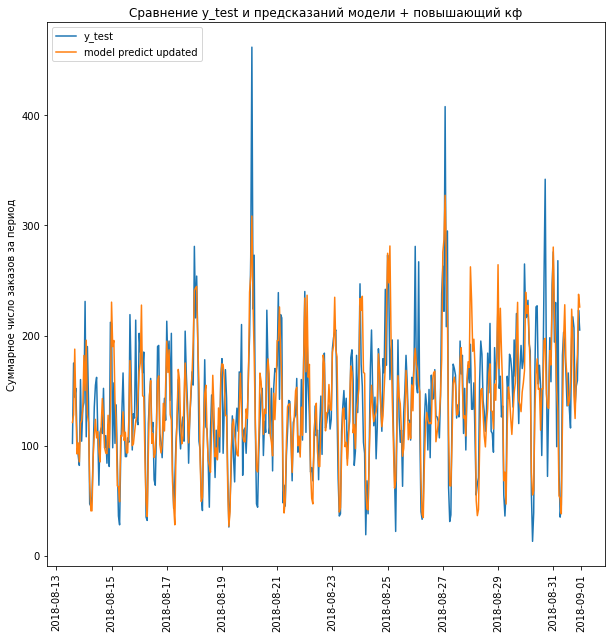

In [ ]:
plt.plot(y_test, label='y_test')
plt.plot(df_model['upd_num_orders_predict'], label='model predict updated')

plt.legend(loc='upper left');

plt.title('Сравнение y_test и предсказаний модели + повышающий кф');

plt.ylabel('Суммарное число заказов за период');

plt.xticks(rotation=90);

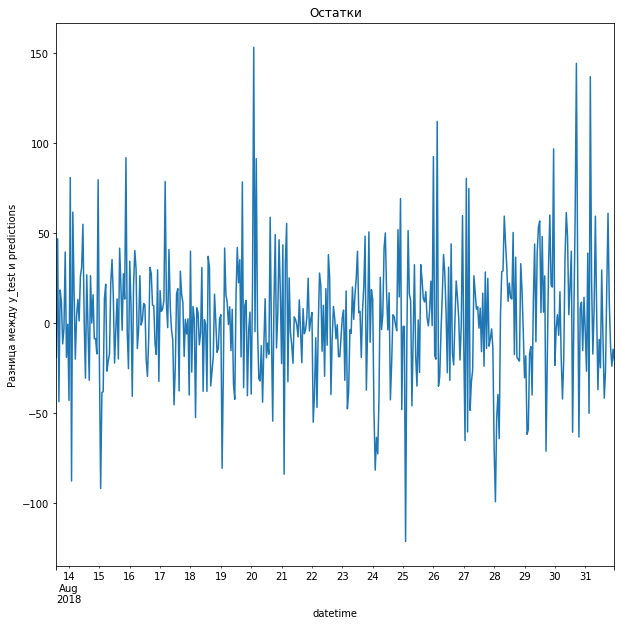

In [ ]:
df_model['upd_residual'] = y_test - df_model['upd_num_orders_predict']

df_model['upd_residual'].plot()

plt.title('Остатки');

plt.ylabel('Разница между y_test и predictions');

In [ ]:
df_model['upd_residual'].mean()

2.221753900562774

Значение метрики RMSE практически не поменялось, а среднее шума уменьшилось в 2 раза, что говорит нам о верности введения повышающего кф

Вывод: полученная метрика RMSE на тестовой выборке меньше, чем требуемая в задании (48), поэтому модель проходит требование по качеству

### Проверка на адекватность

Создадим наивную модель, которая будет предсказывать x(t) = x(t-1)

In [ ]:
predictions_previous = y_test.shift()
predictions_previous.iloc[0] = y_train.iloc[-1]
predictions_previous.head()

datetime
2018-08-13 14:00:00    119.0
2018-08-13 15:00:00    102.0
2018-08-13 16:00:00    175.0
2018-08-13 17:00:00    144.0
2018-08-13 18:00:00    152.0
Freq: H, Name: num_orders, dtype: float64

In [ ]:
y_test.head()

datetime
2018-08-13 14:00:00    102
2018-08-13 15:00:00    175
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
Freq: H, Name: num_orders, dtype: int64

Видим, что значения в predictions_previous корректные

In [ ]:
RMSE_previous = mean_squared_error(y_test, predictions_previous, squared=False)

print(f'RMSE previous = {RMSE_previous}')

RMSE previous = 58.856486242815066


In [ ]:
print(f'RMSE_test for best model = {RMSE_test}')

RMSE_test for best model = 34.52644834849409


Видим, что выбранная нами модель предсказывает значения лучше, чем наивная модель

### Вывод

В процессе анализа данных было выявлено:
- стационарность ряда по стат тесту Дики-Фулера
- рост числа заказов от марта к августу
- дневная и недельная сезонность (по результатам проверки на автокорреляцию)

Выполнена подготовка признаков:
- дневную и недельную сезонность заложили, взяв лаг 168 часов
- тренд заложили, взяв МА 24 часа

Проведено обучение моделей:
- линейной регресии (RMSE train 22.7)
- CatBoost (RMSE train 23.5)

Проведено тесторование лучшей модели на тестовой выборке и получен RMSE 35, что меньше требуемых в задании 48

Выполнена проверка лучшей модели на адекватность, путем сравнения метрики RMSE  с метрикой наивной модели, которая предсказывает x(t)=x(t-1)

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48